In [ ]:
pip install requests beautifulsoup4 nltk

In [ ]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import heapq
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

class NLTKResourceManager:
    """Handles NLTK resource downloads and fallbacks"""
    def __init__(self):
        self.resources = {
            'punkt': ['punkt', 'tokenizers/punkt'],
            'stopwords': ['stopwords'],
            'wordnet': ['wordnet'],
            'omw': ['omw-1.4']
        }

    def ensure_resources(self):
        """Ensure all required resources are available"""
        for resource_name, paths in self.resources.items():
            for path in paths:
                try:
                    nltk.data.find(path)
                    break
                except LookupError:
                    try:
                        nltk.download(resource_name)
                        break
                    except:
                        continue

def fetch_article_text(url):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        paragraphs = soup.find_all(['p', 'h1', 'h2', 'h3'])
        article_text = ' '.join([p.get_text().strip() for p in paragraphs if p.get_text().strip()])

        return article_text
    except Exception as e:
        print(f"Error fetching article: {e}")
        return None

def clean_summary(summary):
    """Clean up the summary text"""
    sentences = list(dict.fromkeys(summary.split('. ')))
    cleaned = '. '.join(sentences).replace('..', '.')
    if cleaned and cleaned[0].islower():
        cleaned = cleaned[0].upper() + cleaned[1:]
    if cleaned and not cleaned.endswith('.'):
        cleaned += '.'
    return cleaned

def summarize_article(text, num_sentences=5):
    if not text or len(text.split()) < 10:
        return "Text too short to summarize"
    resource_manager = NLTKResourceManager()
    resource_manager.ensure_resources()

    try:
        sentences = sent_tokenize(text)
    except:
        sentences = [s.strip() for s in re.split(r'[.!?]', text) if s.strip()]

    if not sentences:
        return text[:500] + "..." if len(text) > 500 else text
    words = re.findall(r'\b\w+\b', text.lower())
    word_freq = defaultdict(int)
    for word in words:
        if word not in stopwords.words('english') and len(word) > 2:
            word_freq[word] += 1

    if not word_freq:
        return clean_summary(" ".join(sentences[:num_sentences]))

    max_freq = max(word_freq.values())
    for word in word_freq:
        word_freq[word] /= max_freq

    sentence_scores = {}
    for i, sentence in enumerate(sentences):
        for word in re.findall(r'\b\w+\b', sentence.lower()):
            if word in word_freq:
                sentence_scores[i] = sentence_scores.get(i, 0) + word_freq[word]

    if not sentence_scores:
        return clean_summary(" ".join(sentences[:num_sentences]))
    top_sentences = []
    seen_sentences = set()
    for i in sorted(sentence_scores, key=sentence_scores.get, reverse=True):
        sent = sentences[i]
        if sent not in seen_sentences:
            seen_sentences.add(sent)
            top_sentences.append(sent)
            if len(top_sentences) >= num_sentences:
                break

    summary = clean_summary(' '.join(top_sentences))
    return summary

if __name__ == "__main__":
    article_url = "https://www.bbc.com/news/world-us-canada-59340789"
    print("Fetching article...")
    article_text = fetch_article_text(article_url)

    if article_text:
        print("Summarizing article...")
        summary = summarize_article(article_text)
        print("\n=== IMPROVED ARTICLE SUMMARY ===")
        print(summary)
    else:
        print("Failed to fetch article.")

Fetching article...
Summarizing article...

=== IMPROVED ARTICLE SUMMARY ===
How US women came to be jailed for miscarriages The looming battle over abortion in the US US top court hears Texas abortion law challenges Campaigner defiant over abortion clinic breach 'I had to use a goods lift to go for an abortion' New York county clerk blocks Texas abortion telehealth suit Rubio dismisses criticism over US response to Myanmar quake The US has been accused of not doing enough to help Myanmar due to the shuttering of its humanitarian aid agency What happens if Roe v Wade is overturned by Supreme Court ruling Women living in about half of all US states could soon lose access to abortion, according to a leaked Supreme Court document A draft opinion from Justice Samuel Alito said the majority of the court's judges favoured overturning the ruling known as Roe v Wade which in 1973 established a woman's right to an abortion There are 13 states that have so-called trigger laws in place, which wou

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!


Please download the dataset from Kaggle and update the path
Top 5 Job Recommendations:

Job Title: Data Scientist
Similarity Score: 0.41
Description: We seek a data scientist with Python and ML experience....

Job Title: Marketing Manager
Similarity Score: 0.05
Description: Marketing manager needed with digital marketing and analytics skills....

Job Title: Software Engineer
Similarity Score: 0.03
Description: Looking for a software engineer proficient in Java and cloud technologies....


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


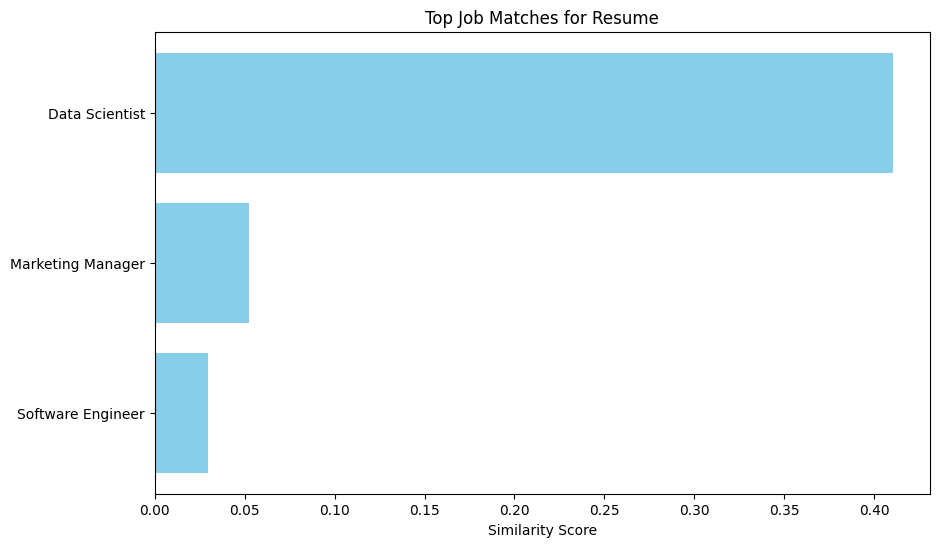

In [ ]:
# %% [markdown]
# # Job Recommendation System using Resume Matching
#
# This system recommends jobs based on text similarity between resumes and job descriptions.

# %%
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# %% [markdown]
# ## 1. Load and Preprocess Data

# %%
# Load job descriptions dataset (replace with your Kaggle dataset path)
# Sample dataset from: https://www.kaggle.com/datasets/promptcloud/job-posting-on-glassdoor
try:
    jobs_df = pd.read_csv("glassdoor_job_postings.csv")  # Update path as needed
except FileNotFoundError:
    print("Please download the dataset from Kaggle and update the path")
    jobs_df = pd.DataFrame({
        'job_title': ['Data Scientist', 'Software Engineer', 'Marketing Manager'],
        'job_description': [
            'We seek a data scientist with Python and ML experience.',
            'Looking for a software engineer proficient in Java and cloud technologies.',
            'Marketing manager needed with digital marketing and analytics skills.'
        ]
    })

# Sample resume text (replace with actual resume text)
resume_text = """
John Doe
Data Science Professional

SKILLS:
- Python, R, SQL
- Machine Learning, Deep Learning
- Data Visualization, Statistical Analysis
- Big Data Technologies (Hadoop, Spark)

EXPERIENCE:
- Data Scientist at ABC Corp (2020-present)
  * Developed ML models for customer segmentation
  * Implemented predictive analytics solutions
  * Created data pipelines using Python and Spark

EDUCATION:
- MS in Data Science, XYZ University
"""

# %% [markdown]
# ## 2. Text Preprocessing

# %%
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    words = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Preprocess job descriptions
jobs_df['processed_description'] = jobs_df['job_description'].apply(preprocess_text)

# Preprocess resume
processed_resume = preprocess_text(resume_text)

# %% [markdown]
# ## 3. Feature Extraction with TF-IDF

# %%
# Combine resume and job descriptions for consistent vectorization
all_texts = [processed_resume] + list(jobs_df['processed_description'])

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

# Separate resume and job vectors
resume_vector = tfidf_matrix[0]
job_vectors = tfidf_matrix[1:]

# %% [markdown]
# ## 4. Calculate Similarity Scores

# %%
# Calculate cosine similarity between resume and each job
similarity_scores = cosine_similarity(resume_vector, job_vectors)

# Add scores to dataframe
jobs_df['similarity_score'] = similarity_scores[0]

# %% [markdown]
# ## 5. Recommend Top Jobs

# %%
# Sort jobs by similarity score
recommended_jobs = jobs_df.sort_values('similarity_score', ascending=False)

# Display top 5 recommendations
print("Top 5 Job Recommendations:")
for i, row in recommended_jobs.head().iterrows():
    print(f"\nJob Title: {row['job_title']}")
    print(f"Similarity Score: {row['similarity_score']:.2f}")
    print(f"Description: {row['job_description'][:200]}...")

# %% [markdown]
# ## 6. Visualization (Optional)

# %%
import matplotlib.pyplot as plt

# Plot top 10 job matches
top_jobs = recommended_jobs.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_jobs['job_title'], top_jobs['similarity_score'], color='skyblue')
plt.xlabel('Similarity Score')
plt.title('Top Job Matches for Resume')
plt.gca().invert_yaxis()  # Highest score at top
plt.show()

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
csv_filename = next(iter(uploaded))
jobs_df = pd.read_csv(csv_filename)
print(jobs_df.head())

Saving indeed_job_dataset.csv to indeed_job_dataset.csv
   Unnamed: 0                                  Job_Title  \
0           0                             Data Scientist   
1           1                             Data Scientist   
2           2                             Data Scientist   
3           3  Graduate Studies Program - Data Scientist   
4           4                           Data Scientist I   

                                                Link Queried_Salary  \
0  https://www.indeed.com/rc/clk?jk=6a105f495c36a...         <80000   
1  https://www.indeed.com/rc/clk?jk=86afd561ea8c6...         <80000   
2  https://www.indeed.com/rc/clk?jk=e0aad317e6d45...         <80000   
3  https://www.indeed.com/rc/clk?jk=1cfdd9e391a63...         <80000   
4  https://www.indeed.com/rc/clk?jk=fec647775a21e...         <80000   

         Job_Type                                              Skill  \
0  data_scientist                                     ['SAP', 'SQL']   
1  data_scie